## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was to rescale, normalize, and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

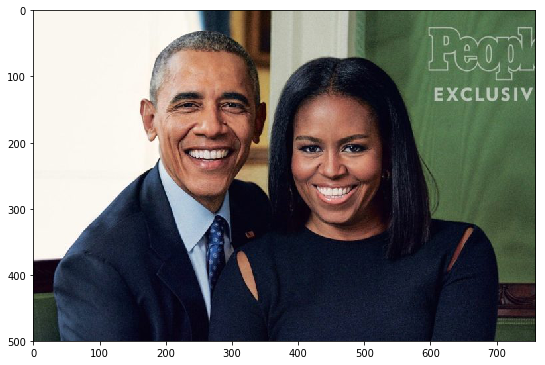

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


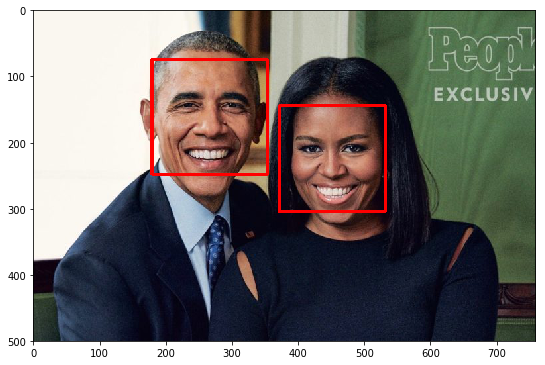

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [4]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=43264, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [18]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[0][:, 0], predicted_key_pts[0][:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [19]:
# visualize the output
def visualize_output(test_image, test_output, index, gt_pts=None):

    plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 2, index+1)

    # un-transform the image data
    image = test_image # get the image from it's Variable wrapper
    image = image.numpy()   # convert to numpy array from a Tensor
    image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

    # un-transform the predicted key_pts data
    predicted_key_pts = test_output.data
    
    predicted_key_pts = predicted_key_pts.numpy()
    
    # undo normalization of keypoints  
    predicted_key_pts = predicted_key_pts*50.0+100 #75.0+75
    #print(predicted_key_pts)
    # plot ground truth points for comparison, if they exist
    ground_truth_pts = None
    if gt_pts is not None:
        ground_truth_pts = gt_pts[i]         
        ground_truth_pts = ground_truth_pts*50.0+100

    # call show_all_keypoints
    show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

    #plt.axis('off')

    plt.show()


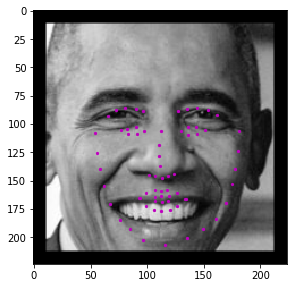

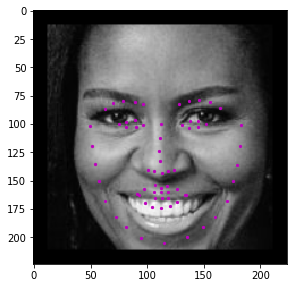

In [26]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for i, (x,y,w,h) in enumerate(faces):
    
    # Select the region of interest that is the face in the image 
#     h = int(1.5*h)
#     w = int(1.5*w)
    #print('h :', h, ' , w: ', w)
    roi = image_copy[y:y+h, x:x+w]
    # Add padding
    roi = cv2.copyMakeBorder(roi,10,10,10,10,cv2.BORDER_CONSTANT,value=1)
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    # if image has no grayscale color channel, add one
    if(len(roi.shape) == 2):
        # add that third color dim
        roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
    roi = torch.from_numpy(roi.transpose((2, 0, 1)))
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    # Convert ROI images to FloatTensors
    img = roi.type(torch.FloatTensor)
    img = img.unsqueeze_(0)
    
    # Forward pass to get net output
    output_pts = net(img)
    #print(output_pts.size())
    #print(output_pts)
    # reshape to batch_size x 68 x 2 pts
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    
    ## Display each detected face and the corresponding keypoints
    visualize_output(roi, output_pts, i)


[[-0.25059339  0.03112489  0.0687834  -0.26831266]
 [-0.25001469 -0.01825348 -0.23364095  0.03907962]
 [-0.15780531  0.16342792  0.20927557  0.07488914]
 [ 0.02522802 -0.25269547 -0.12976182  0.16259007]]
(4, 4)


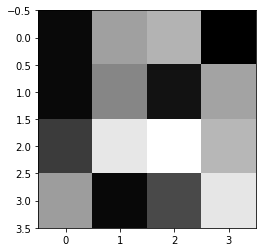

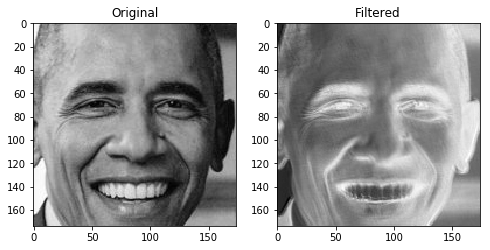

In [43]:
### Testing ####

weights1 = net.conv1.weight.data

w = weights1.numpy()
f_filter = w[0][0]

print(f_filter)
print(f_filter.shape)

# display the filter weights
plt.imshow(f_filter, cmap='gray') 
(x, y, w, h) = faces[0]
img = cv2.cvtColor(image_copy[y:y+h, x:x+w], cv2.COLOR_RGB2GRAY)/255.0
filtered = cv2.filter2D(img, -1, f_filter)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))


ax1.set_title('Original')
ax1.imshow(np.squeeze(img), cmap='gray')

ax2.set_title('Filtered')
ax2.imshow(filtered, cmap='gray')

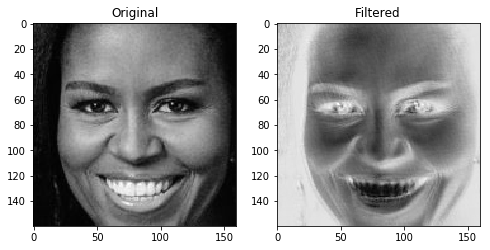

In [44]:
(x, y, w, h) = faces[1]
img = cv2.cvtColor(image_copy[y:y+h, x:x+w], cv2.COLOR_RGB2GRAY)/255.0
filtered = cv2.filter2D(img, -1, f_filter)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))


ax1.set_title('Original')
ax1.imshow(np.squeeze(img), cmap='gray')

ax2.set_title('Filtered')
ax2.imshow(filtered, cmap='gray')

[[-0.05506613  0.02275014 -0.06018602]
 [-0.05213752 -0.03596003 -0.04276429]
 [-0.04332739  0.0027417  -0.00159687]]
(3, 3)


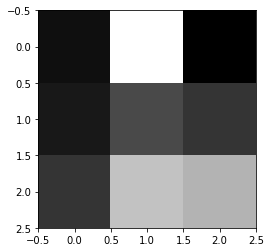

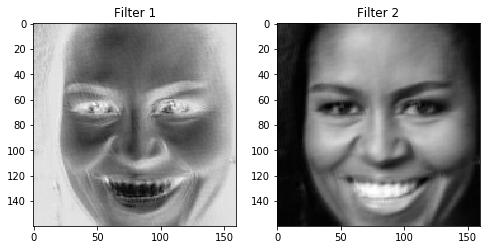

In [47]:
weights2 = net.conv2.weight.data

w = weights2.numpy()
f_filter = w[0][0]

print(f_filter)
print(f_filter.shape)

# display the filter weights
plt.imshow(f_filter, cmap='gray') 
# (x, y, w, h) = faces[1]
# img = cv2.cvtColor(image_copy[y:y+h, x:x+w], cv2.COLOR_RGB2GRAY)/255.0
filter2 = cv2.filter2D(filtered, -1, f_filter)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))


ax1.set_title('Filter 1')
ax1.imshow(filtered, cmap='gray')

ax2.set_title('Filter 2')
ax2.imshow(filter2, cmap='gray')

[[ 0.00798731  0.05107569]
 [ 0.01110667 -0.01413526]]
(2, 2)


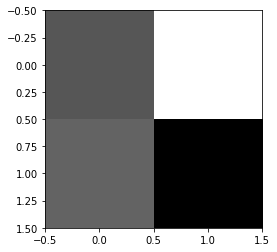

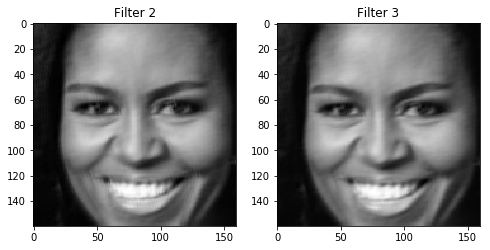

In [49]:
weights3 = net.conv3.weight.data

w = weights3.numpy()
f_filter = w[0][0]

print(f_filter)
print(f_filter.shape)

# display the filter weights
plt.imshow(f_filter, cmap='gray') 
# (x, y, w, h) = faces[1]
# img = cv2.cvtColor(image_copy[y:y+h, x:x+w], cv2.COLOR_RGB2GRAY)/255.0
filter3 = cv2.filter2D(filter2, -1, f_filter)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))


ax1.set_title('Filter 2')
ax1.imshow(filter2, cmap='gray')

ax2.set_title('Filter 3')
ax2.imshow(filter3, cmap='gray')

[[ 0.07065012]]
(1, 1)


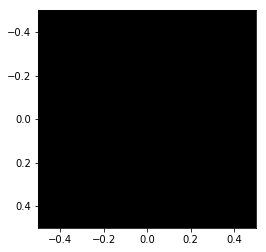

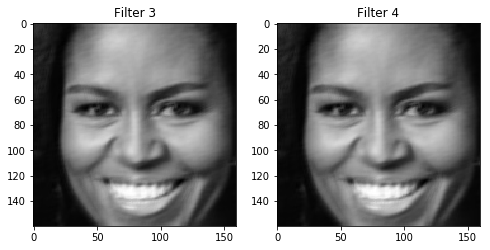

In [50]:
weights4 = net.conv4.weight.data

w = weights4.numpy()
f_filter = w[0][0]

print(f_filter)
print(f_filter.shape)

# display the filter weights
plt.imshow(f_filter, cmap='gray') 
# (x, y, w, h) = faces[1]
# img = cv2.cvtColor(image_copy[y:y+h, x:x+w], cv2.COLOR_RGB2GRAY)/255.0
filter4 = cv2.filter2D(filter3, -1, f_filter)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))


ax1.set_title('Filter 3')
ax1.imshow(filter3, cmap='gray')

ax2.set_title('Filter 4')
ax2.imshow(filter4, cmap='gray')